In [9]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import argparse
import os
from tqdm import tqdm
import time
import math
import json

from net.network import SelfAttention, vgg_reverse, vgg
from net.models import Transform, SAVA_test
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
parser = argparse.ArgumentParser()
# Basic options
parser.add_argument('--content_dir', type=str, default='../style-transfer-with-style-attention/datasets/content_set/val2014',
                    help='Directory path to a batch of content images')
parser.add_argument('--style_dir', type=str, default='../style-transfer-with-style-attention/datasets/style_set/val2014',
                    help='Directory path to a batch of content images')
parser.add_argument('--vgg_model', type=str, default='./models/vgg/vgg_normalised.pth')
parser.add_argument('--attn_model', type=str, default='./models/attention_training/attention_kernel_iter_80000.pth')

# training options
parser.add_argument('--save_dir', default='./models/sava_training',
                    help='Directory to save the model')
parser.add_argument('--log_dir', default='./logs',
                    help='Directory to save the log')
parser.add_argument('--lr', type=float, default=1e-4)
parser.add_argument('--lr_decay', type=float, default=5e-5)
parser.add_argument('--max_iter', type=int, default=160000)
parser.add_argument('--batch_size', type=int, default=5)
parser.add_argument('--n_threads', type=int, default=16)
parser.add_argument('--save_model_interval', type=int, default=1000)
parser.add_argument('--start_iter', type=float, default=0)
parser.add_argument('--seperate', type=bool, default=False)
args = parser.parse_args('')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

In [4]:
# transforms.Normalize((0, 0, 0), (1/255.0, 1/255.0, 1/255.0))
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
    ]),
}

class FlatFolderDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = os.listdir(self.root)
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

def InfiniteSampler(n):
    # i = 0
    i = n - 1
    order = np.random.permutation(n)
    while True:
        yield order[i]
        i += 1
        if i >= n:
            np.random.seed()
            order = np.random.permutation(n)
            i = 0


class InfiniteSamplerWrapper(torch.utils.data.sampler.Sampler):
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 31

content_set = FlatFolderDataset(args.content_dir, data_transforms['train'])
style_set = FlatFolderDataset(args.style_dir, data_transforms['train'])

content_loader = torch.utils.data.DataLoader(
    content_set, batch_size=args.batch_size,
    sampler=InfiniteSamplerWrapper(content_set),
    num_workers=args.n_threads)
style_loader = torch.utils.data.DataLoader(
    style_set, batch_size=args.batch_size,
    sampler=InfiniteSamplerWrapper(style_set),
    num_workers=args.n_threads)

content_iter = iter(content_loader)
style_loader = iter(style_loader)

torch.Size([3, 256, 256])


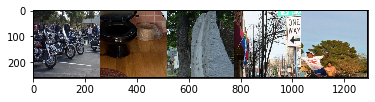

In [5]:

# functions to show an image

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(content_loader)
images = dataiter.next()
print(images[0].size())
# show images
imshow(torchvision.utils.make_grid(images))


torch.Size([3, 256, 256])


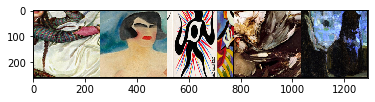

In [6]:
# get some random training images
dataiter = iter(style_loader)
images = dataiter.next()
print(images[0].size())
# show images
imshow(torchvision.utils.make_grid(images))


In [7]:
def get_optimizer(model):
    
    for param in model.encode.parameters():
        param.requires_grad = False
    
    for param in model.transformer.savanet4_1.self_attn.parameters():
        param.requires_grad = False
    
    for param in model.transformer.savanet5_1.self_attn.parameters():
        param.requires_grad = False
    
    optimizer = torch.optim.Adam([
        {'params': model.decode.parameters()},
        {'params': model.transformer.parameters()},
    ], lr=args.lr)
    return optimizer

def state_to_device(parameter, device):
    state_dict = parameter.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    parameter.cuda()
        
encoder = vgg
encoder.load_state_dict(torch.load(args.vgg_model))
state_to_device(encoder, device)

self_attn = SelfAttention()
self_attn.load_state_dict(torch.load(args.attn_model))
state_to_device(self_attn, device)
transformer = Transform(in_channel = 512, self_attn=self_attn)

decoder = vgg_reverse

if(args.start_iter > 0):

    decoder.load_state_dict(torch.load(args.save_dir + '/decoder_iter_' + str(args.start_iter) + '.pth'))
    state_to_device(decoder, device)
    
    transformer.load_state_dict(torch.load(args.save_dir + '/transformer_iter_' + str(args.start_iter) + '.pth'))
    state_to_device(transformer, device)
    
    model = SAVA_test(transformer=transformer, encoder=encoder, decoder=decoder)
    optimizer = get_optimizer(model)
    optimizer.load_state_dict(torch.load(args.save_dir + '/optimizer_iter_' + str(args.start_iter) + '.pth'))
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()
else:
    model = SAVA_test(transformer=transformer, encoder=encoder, decoder=decoder)
    optimizer = get_optimizer(model)

model.to(device)   
loss_seq = {'total': [], 'content': [], 'style': [], 'identity1': [], 'identity2': []}

In [8]:
def lastest_arverage_value(values, length=100):
    if len(values) < length:
        length = len(values)
    return sum(values[-length:])/length

def adjust_learning_rate(optimizer, iteration_count):
    """Imitating the original implementation"""
    lr = args.lr / (1.0 + args.lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [10]:
content_reload_period = len(content_loader.dataset) / args.batch_size
content_reload_period = math.floor(content_reload_period)

style_reload_period = len(style_loader.dataset) / args.batch_size
style_reload_period = math.floor(style_reload_period)

for i in tqdm(range(args.start_iter, args.max_iter)):
    adjust_learning_rate(optimizer, iteration_count=i)
    
    if (i - args.start_iter)%content_reload_period == 0:
        content_loader = torch.utils.data.DataLoader(
            content_set, batch_size=args.batch_size,
            sampler=InfiniteSamplerWrapper(content_set),
            num_workers=args.n_threads)
        content_iter = iter(content_loader)
    
    if (i - args.start_iter)%style_reload_period == 0:
        style_loader = torch.utils.data.DataLoader(
            style_set, batch_size=args.batch_size,
            sampler=InfiniteSamplerWrapper(style_set),
            num_workers=args.n_threads)
        style_iter = iter(style_loader)
    
    content_images = next(content_iter).to(device)
    style_images = next(style_iter).to(device)
    losses = model(content_images, style_images)
        
    total_loss = losses['total']
    
    for name, vals in loss_seq.items():
        loss_seq[name].append(losses[name].item())
        
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if (i + 1) % args.save_model_interval == 0 or (i + 1) == args.max_iter:
        print("%s: Iteration: [%d/%d]\tRecon Loss: %2.4f\tStyle Loss: %2.4f\tIdentity1 Loss: %2.4f\Identity2 Loss: %2.4f\tTotal: %2.4f"%(time.ctime(),i+1, 
                args.max_iter, lastest_arverage_value(loss_seq['content']), lastest_arverage_value(loss_seq['style']), 
                lastest_arverage_value(loss_seq['identity1']), lastest_arverage_value(loss_seq['identity2']), lastest_arverage_value(loss_seq['total'])))

        state_dict = model.decode.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].to(torch.device('cpu'))
        torch.save(state_dict,
                    '{:s}/decoder_iter_{:d}.pth'.format(args.save_dir,
                                                            i + 1))
        state_dict = model.transformer.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].to(torch.device('cpu'))
        torch.save(state_dict,
                    '{:s}/transformer_iter_{:d}.pth'.format(args.save_dir,
                                                            i + 1))
        state_dict = optimizer.state_dict()
        torch.save(state_dict,
                    '{:s}/optimizer_iter_{:d}.pth'.format(args.save_dir,
                                                            i + 1))
        
        with open(args.save_dir + "/losses.json", 'w') as f:
            json.dump(losses, f)
    
    

SyntaxError: invalid syntax (<ipython-input-10-5439fab3a7dc>, line 59)